# Set up

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 차원축소

많은 경우 머신러닝 문제는 훈련 샘플이 각각이 수천 심지어 수백만 개의 특성을 가지고 있습니다.  
이는 훈련을 느리게 할 뿐만 아니라, 앞으로 보게 되겠지만 좋은 솔루션을 찾기 어렵게 만듭니다.  
이런 문제를 종종 
### 차원의 저주 라고 합니다.

차원을 축소시키면 일부 정보가 유실됩니다.  
그래서 훈련 속도가 빨라질 수는 있지만 시스템의 성능이 조금 나빠질 수 있습니다.  
그러므로 차원 축소를 고려하기 전에 훈련이 너무 느린지 먼저 원본 데이터로 시스템을 훈련시켜 봐야 합니다.

차원 축소는 훈련 속도를 높이는 것 외에 데이터 시각화 (data visualization)에도 아주 유용합니다.

# 8.1 차원의 저주

훈련 세트의 차원이 클수록 과대적합의 위험이 커집니다.

이론적으로 차원의 저주를 해결하는 해결책 하나는 훈련 샘플의 밀도가 충분히 높아질 때까지 훈련 세트의 크기를 키우는 것입니다.  
이는 불가능합니다.  
차원이 하나 늘어날때마다 늘어나야 하는 훈련 샘플의 수는 기하 급수적으로 증가합니다.

# 8.2 차원 축소를 위한 접근 방법

차원을 감소시키는 두 가지 주요한 접근법인 투영(projection)과 매니폴드 학습(Manifold Learning)을 살펴 보겠습니다.

## 8.2.1 투영(projection)

대부분의 실전문제는 훈련 샘플이 모든 차원에 걸쳐 균일하게 퍼져 있지 않습니다.  
다른 특성들은 서로 강하게 연관되어 있습니다.  
결과적으로 모든 훈련 샘플이 사실 고차원 공간 안의 저차원 부분공간에 놓여 있습니다.  

예를 들어 공간 형태의 3차원 데이터셋을 2차원의 평면위로, 이 부분공간에 수직으로(즉, 샘플과 평면 사이의 가장 짧은 직선을 따라) 투영하면 2차원의 데이터셋을 얻을 수 있습니다.  
즉 3차원의 데이터를 2차원으로 줄입니다.  

그러나 차원 축소에 있어서 투영이 언제나 최선의 방법은 아닙니다.  
많은 경우 같은 3차원공간이라고 해도 공간이 휘어있거나 부분공간이 뒤틀려 있기도 합니다.  

이러한 경우 부분공간에 수직으로 투영된 데이터들이 겹치고 뭉개져 버립니다.  

먼저 3d dataset을 만들고 sklearn 의 PCA를 이용하여 특징추출하는 걸 한번 해보겠습니다

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [4]:
print(X[:, 0])
print(X[:, 1])
print(X[:, 2])

[-1.01570027 -0.00771675 -0.95317135 -0.92012304 -0.76309739  1.11816122
 -1.02258878  0.67351984  1.01619558  0.54957723 -0.98960443  1.13248106
 -0.99337712 -0.94763679  1.10095709 -0.34604591  0.69102621  0.68302902
  0.8774031  -1.06090127  0.52336644 -0.94419403 -0.9716288  -1.10560661
  1.1748694   0.91337123 -0.28688829  1.10247263 -0.93581594  0.6617217
  0.09896169 -1.08103158  0.03004261  0.97846627  0.97257451 -0.06924261
  0.01690169 -0.40544483  0.64162827 -0.64012055  0.7326402  -0.44999735
 -0.98461065  1.11939222  0.78441066  0.16636498 -0.67371747  1.11429663
 -0.11381596 -0.45471725 -1.15790478  0.83494104 -0.46940298  1.14845951
  0.24039921  1.10567699 -1.01152009  0.52519411 -1.09575714  0.58692443]
[-0.55091331  0.59958572 -0.46453691  0.21009593  0.158261    0.32508721
 -0.64384064 -0.27342519  0.51546608  0.67728016  0.00886617  0.28229967
 -0.26832824 -0.4995849   0.1706481   0.45334414 -0.27337761  0.70421846
 -0.16775101 -0.48213721  0.66585845 -0.61502157  0

In [5]:
X[:5]

array([[-1.01570027, -0.55091331, -0.26132626],
       [-0.00771675,  0.59958572,  0.03507755],
       [-0.95317135, -0.46453691, -0.24920288],
       [-0.92012304,  0.21009593,  0.02182381],
       [-0.76309739,  0.158261  ,  0.19152496]])

In [6]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [7]:
X3D_inv = pca.inverse_transform(X2D)

In [8]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [9]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [10]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [11]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

In [12]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [13]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

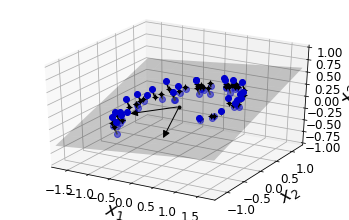

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

plt.show()

모든 샘플이 거의 평면 형태로 놓여 있습니다.  
이것이 고차원(3D) 공간에 있는 저차원(2D) 부분 공간입니다.  
여기서 모든 훈련 샘플이 이 부분공간에 수직으로 투영하면 다음 코드의 결과물과 같은 그림을 얻습니다.

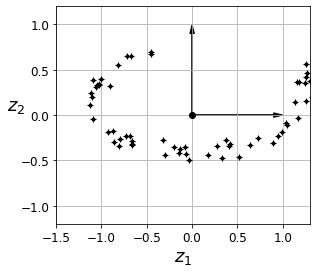

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

그러나 차원 축소에 있어서 투영이 언제나 최선의 방법은 아닙니다.  
스위스 롤(swiss roll) 데이터셋처럼 부분 공간이 뒤틀리거나 휘어 있으면 단순히 투영만으로는 해결이 안됩니다.

## 8.2.2 매니폴드 학습(Manifold Learning)

부분공간에서 뭉친 데이터 부분(스위스 롤)은 2D 매니폴드의 한 예입니다.  
간단히 말해 2D 매니폴드는 고차원 공간에서 휘어지거나 뒤틀린 2D 모양입니다.  
더 일반적으로는 d차원 매니폴드는 국부적으로 d차원 초평면으로 보일 수 있는 n차원 공간의 일부입니다.(d < n)  
스위스 롤 같은경우는 d = 2 , n = 3 입니다.  
  
  
많은 차원 축소 알고리즘이 훈련 샘플이 놓여 있는 매니폴드를 모델링하는 식으로 작동합니다.  
이를 매니폴드 학습(manifold learning) 이라고 합니다.  

많은 이는 대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 매니폴드 가정(manifold assumption)또는 매니폴드 가설(manifold hypothesis)에 근거합니다.  



요약하면 모델을 훈련시키기 전에 훈련 세트의 차원을 감소시키면 훈련 속도는 빨라지지만 항상 더 낫거나 간단한 솔루션이 되는건 아닙니다.  

이제 차원의 저주가 무엇인지, 특히 매니폴드 가정이 성립할 때 차원 축소 알고리즘이 어떻게 작동하는지 감을 잡았길 바랍니다.  
이 다음 내용 부터는 가장 널리 알려진 알고리즘 중 일부를 살펴보겠습니다.  

In [16]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

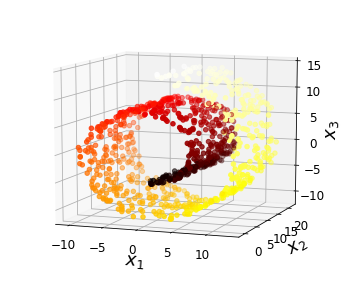

In [17]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()

위 그림처럼 많은 경우가 부분 공간이 뒤틀리거나 휘어 있습니다(스위스 롤)

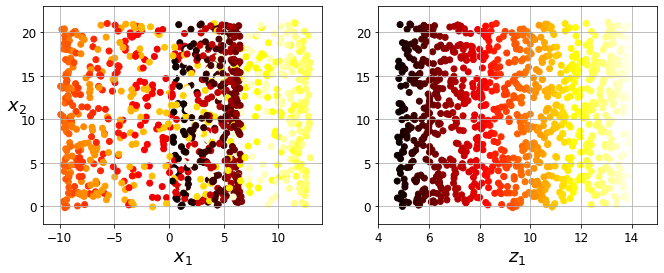

In [18]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

스위스롤은 그냥 투영을 시키면 왼쪽그림처럼 스위스 롤의 층이 서로 뭉개집니다. 하지만 우리가 원하는 것은 스위스 롤을 펼쳐서 오른쪽처럼 2D 데이터셋을 얻는것 입니다

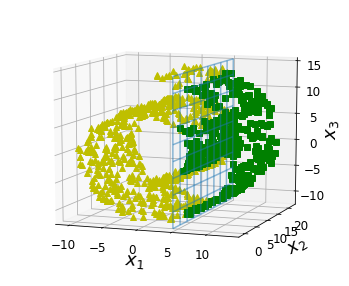

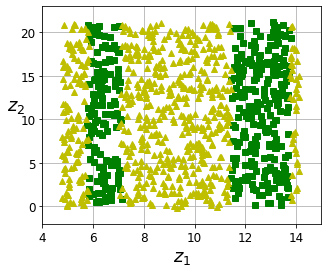

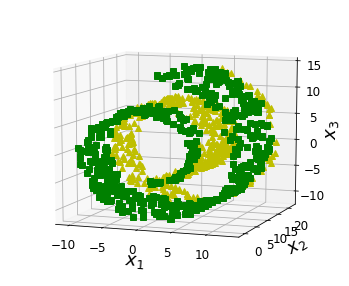

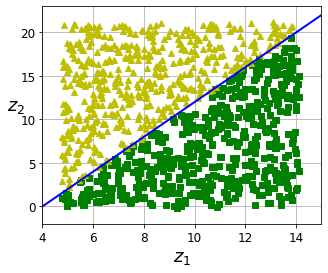

In [19]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

위 그림은 저차원에서 항상 결정경계가 간단한 형태가 아니라는걸 보여줍니다.  
  
모델을 훈련시키기 전에 훈련 세트의 차원을 감소시키면 훈련 속도는 빨라지지만 항상 더 낫거나 간단한 솔루션이 되는 것은 아닙니다.
전적으로 데이터셋에 달렸습니다.

이제 차원의 저주가 무엇인지 살펴보았고 가장 널리 알려진 알고리즘 중 일부를 살펴 보도록 하겠습니다.

# 8.3 PCA

주성분 분석 (Principal Component Analysis) 은 가장 인기 있는 차원 축소 알고리즘입니다.  
먼저 데이터에 가장 가까운 초평면을 정의한 다음, 데이터를 이 평면에 투영시킵니다.

## 8.3.1 분산 보존

저차원의 초평면에 훈련 세트를 투영하기 전에 먼저 올바른 초평면을 선택해야 합니다.  
투영할 부분 공간을 선택할 때 분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실되므로 합리적입니다.  


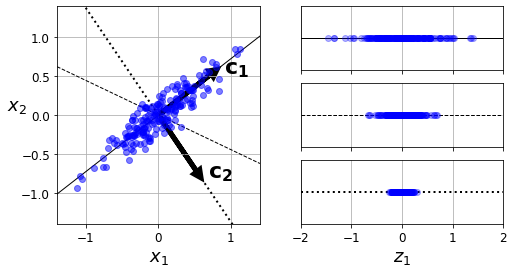

In [20]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

다른 방향으로 투영하는 것보다 분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실되므로 합리적으로 보입니다.  
이 선택을 다른 방식으로 설명하면 원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화하는 축입니다.  

## 8.3.2 주성분(PC)

PCA는 훈련 세트에서 분산이 최대인 축을 찾습니다.
  
  
훈련세트의 주성분은 특잇값 분해 (SVD)라는 표준 행렬 분해 기술이 있어서 훈련 세트 행렬 X를 세 개의 점곱으로 분해할 수 있습니다.  
  
다음 파이썬 코드는 넘파이의 svd 함수를 사용해 훈련 세트의 모든 주성분을 구한 후 처음 두 개의 PC를 추출합니다.

In [21]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [22]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

PCA는 데이터셋의 평균이 0이라고 가정합니다.  
앞으로 볼 사이킷런의 PCA 파이썬 클래스는 이 작업을 대신 처리해줍니다.  
그러나 PCA를 직접 구현하거나 다른 라이브러리를 사용한다면 먼저 데이터를 원점에 맞추는 것을 잊어서는 안 됩니다.  

## 8.3.3 d차원으로 투영하기

주성분을 모두 추출해냈다면 처음 d개의 주성분으로 정의한 초평면에 투영하여 데이터셋의 차원을 d차원으로 축소시킬 수 있습니다.  
이 초평면은 분산을 가능한 한 최대로 보존하는 투영입니다.  
초평면에 훈련 세트를 투영하기 위해서는 행렬 X와 첫 d개의 주성분을 담은 V (즉, V의 첫d열로 구성된) 행렬 Wd를 점곱하면 됩니다.  
X_d-proj = X Wd

다음 파이썬 코드는 첫 두 개의 주성분으로 정의된 평면에 훈련 세트를 투영합니다

In [23]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

## 8.3.4 사이킷런 사용하기

사이킷런의 PCA 모델은 앞서 한 것처럼 같은 방법을 사용하여 구현합니다.  
다음은 PCA모델을 사용해 데이터셋의 차원을 2로 줄이는 코드입니다 ( 사이킷런의 PCA모델은 자동으로 데이터를 중앙에 맞춰줍니다.)

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [25]:
print(X[:, 0])
print(X[:, 1])
print(X[:, 2])

[-1.01570027 -0.00771675 -0.95317135 -0.92012304 -0.76309739  1.11816122
 -1.02258878  0.67351984  1.01619558  0.54957723 -0.98960443  1.13248106
 -0.99337712 -0.94763679  1.10095709 -0.34604591  0.69102621  0.68302902
  0.8774031  -1.06090127  0.52336644 -0.94419403 -0.9716288  -1.10560661
  1.1748694   0.91337123 -0.28688829  1.10247263 -0.93581594  0.6617217
  0.09896169 -1.08103158  0.03004261  0.97846627  0.97257451 -0.06924261
  0.01690169 -0.40544483  0.64162827 -0.64012055  0.7326402  -0.44999735
 -0.98461065  1.11939222  0.78441066  0.16636498 -0.67371747  1.11429663
 -0.11381596 -0.45471725 -1.15790478  0.83494104 -0.46940298  1.14845951
  0.24039921  1.10567699 -1.01152009  0.52519411 -1.09575714  0.58692443]
[-0.55091331  0.59958572 -0.46453691  0.21009593  0.158261    0.32508721
 -0.64384064 -0.27342519  0.51546608  0.67728016  0.00886617  0.28229967
 -0.26832824 -0.4995849   0.1706481   0.45334414 -0.27337761  0.70421846
 -0.16775101 -0.48213721  0.66585845 -0.61502157  0

In [26]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

PCA 변환기를 데이터셋에 학습시키고 나면 components_ 변수를 사용해 주성분을 확인할 수 있습니다.  
이 변수에는 주성분이 행 벡터로 포함되어 있으므로 첫 번째 주성분은   
pca.components_.T[:, 0] 이 됩니다

## 8.3.5 설명된 분산의 비율

explained_variance_ratio_ 변수에 저장된 주성분의 설명된 분산의 비율(explained variance ratio)도 유용한 정보 중 하나입니다.  
이 값은 각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타냅니다.  

In [27]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

이는 데이터셋 분산의 84.2%가 첫 번째 축에 놓여 있고 14.6% 가 두 번째 축에 놓여 있음을 알려줍니다.  
세번째 축에는 1.2% 미만이 남아 있을 것이므로 아주 적은 양의 정보가 들어 있다고 생각해도 됩니다.

## 8.3.6 적절한 차원 수 선택하기

축소할 차원 수를 임의로 정하기보다는 충분한 분산(예를들면 95%)이 될 때까지 더해야 할 차원의 수를 선택하는 쪽을 더 선호합니다.  
물론 데이터 시각화를 위해 차원을 축소하는 경우에는 차원을 2개나 3개로 줄이는 것이 일반적입니다.  
  
다음 코드는 차원을 축소하지 않고 PCA를 계산한 뒤 훈련 세트의 분산을 95%로 유지하는 데 필요한 최소한의 차원 수를 계산합니다.

In [28]:
from six.moves import urllib
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [29]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [30]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_) #각 원소들의 누적 합을 표시함
d = np.argmax(cumsum >=0.95) + 1

In [31]:
d

154

In [32]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

그런 다음 n_components = d 로 설정하여 PCA를 다시 실행합니다.  
하지만 유지하려는 주성분의 수를 지정하기보다는 보존하려는 분산의 비율을 n_components에 0.0에서 1.0 사이로 설정하는 편이 훨씬 낫습니다.

또 다른 방법은 설명된 분산을 차원 수에 대한 함수로 그리는 것입니다.  
일반적으로 이 그래프에는 설명된 분산의 빠른 성장이 멈추는 변곡점이 있습니다.  
이를 데이터셋에 내재된 고유 차원으로 생각할 수 있습니다.  
여기서는 차원을 약 100으로 축소해도 설명된 분산을 크게 손해 보지 않을 것입니다.  


## 8.3.7 압축을 위한 PCA

확실히 차원을 축소하고 난 후에는 훈련 세트의 크기가 줄어듭니다.  
예를 들어 MNIST 데이터셋에 분산의 95%를 유지하도록 PCA를 적용해보겠습니다.  
각 샘플은 원래의 784개의 특성이 아니라 150개 정도만 가지고 있을 것입니다.
  
  
대부분의 분산은 유지되었지만 데이터셋은 원본 크기의 20% 미만이 되었습니다.  
이는 상당한 압축률이고 (SVM) 과 같은 분류 알고리즘의 속도를 크게 높일 수 있습니다.  
  
또한 압축된 데이터셋에 PCA 투영의 변환을 반대로 적용하여 784개의 차원으로 되돌릴 수도 있습니다.  

물론 투영에서 일정량의 정보(유실된 5%의 분산)를 잃어버렸기 때문에 이렇게 해도 원본 데이터셋을 얻을 수는 없습니다.  

하지만 원본데이터와 매우 비슷할 것입니다.  
  
  
원본 데이터와 재구성된 데이터 사이의 평균 제곱 거리를 재구성 오차(reconstruction error) 라고 합니다.  


In [33]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [34]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

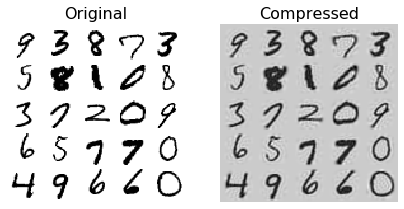

In [35]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

위 그림은 X_reduced 에다가 PCA의 inverse_transform() 메서드를 이용해 784차원으로 복원한 것이다.

In [36]:
X_reduced_pca = X_reduced

## 8.3.8 점진적 PCA (IPCA)

PCA 구현의 문제는 SVD 알고리즘을 실행하기 위해 전체 훈련 세트를 메모리에 올려야 한다는 것입니다.  
다행히 점진적 PCA(Incremental PCA) 알고리즘이 개발되었습니다.  
훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한 번에 하나씩 주입합니다.  
이런 방식은 훈련 세트가 클 때 유용하고 온라인으로 (즉, 새로운 데이터가 준비되는 대로 실시간으로 업데이트 되는) PCA를 적용할 수 도 있습니다.  

다음 코드는 MNIST 데이터셋을 (넘파이의 array_split() 함수를 사용해) 100개의 미니배치로 나누고 사이킷런의 IncrementalPCA 파이썬 클래스에 주입하고 MNIST 데이터셋의 차원을 154개로 줄입니다. 
전체 훈련 세트를 사용하는 fit() 메서드가 아니라 partial_fit() 메서드를 미니배치마다 호출해야 합니다.  

In [37]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches) : 
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

In [38]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

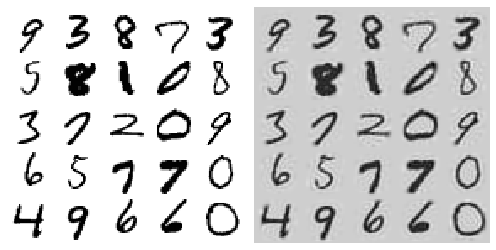

In [39]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

또 다른 방법은 넘파이의 memmap 파이썬 클래스를 사용해 하드 디스크의 이진 파일에 저장된 매우 큰 배열을 메모리에 들어 있는 것처럼 다루는 것입니다. 이 파이썬 클래스는 필요할 때 데이터를 메모리에 적재합니다.   
IncrementalPCA는 특정 순간에 배열의 일부만 사용하기 때문에 메모리 부족 문제를 해결할 수 있습니다.  
다음 코드처럼 이 방식을 적용하면 일반적인 fit() 메서드를 사용할 수 있습니다

In [40]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [41]:
del X_mm

In [42]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [43]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## 8.3.8 랜덤 PCA 

사이킷런에는 PCA의 또 다른 옵션으로 랜덤PCA 를 제공합니다.  
이 방식은 확률적인 알고리즘으로, 첫 d개의 주성분에 대한 근삿값을 빠르게 찾습니다. 이 알고리즘의 계산 복잡도를 보면 d가 n보다 많이 작으면 앞선 알고리즘보다 매우 빨라집니다.  

In [44]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 2.4 seconds
    IncrementalPCA: 27.2 seconds
    PCA: 2.8 seconds
n_components = 10
    PCA: 3.6 seconds
    IncrementalPCA: 33.8 seconds
    PCA: 4.5 seconds
n_components = 154
    PCA: 10.6 seconds
    IncrementalPCA: 46.8 seconds
    PCA: 11.9 seconds


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

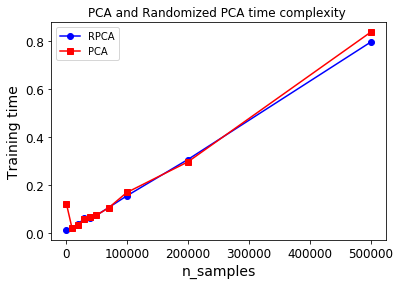

In [45]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

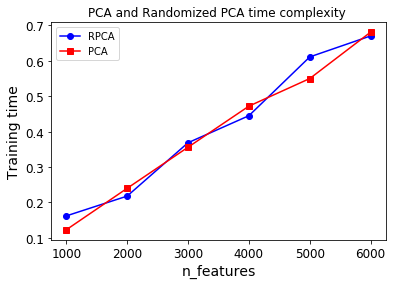

In [46]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# 8.4 커널 PCA

5장 SVM 에서 샘플을 매우 높은 고차원 공간으로 암묵적으로 매핑하여 서포트 벡터 머신의 비선형 분류와 회귀를 가능하게 하는 수학적 기법인 커널 트릭에 대해 이야기 했습니다.  
고차원 특성 공간에서의 선형 결정 경계는 원본 공간에서는 복잡한 비선형 결정 경계에 해당한다는 것을 배웠습니다.  
  
같은 기법을 PCA에 적용해 차원 축소를 위한 복잡한 비선형 투형을 수행할 수 있습니다.   
이를 커널 PCA(kernel PCA)(kPCA)라고 합니다.  

이 기법은 투영된 후에 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 때도 유용합니다.  

  
  
예를들어 다음 코드는 사이킷런의 KernelPCA를 사용해 RBF 커널로 kPCA를 적용하고 있습니다.  

In [47]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [48]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

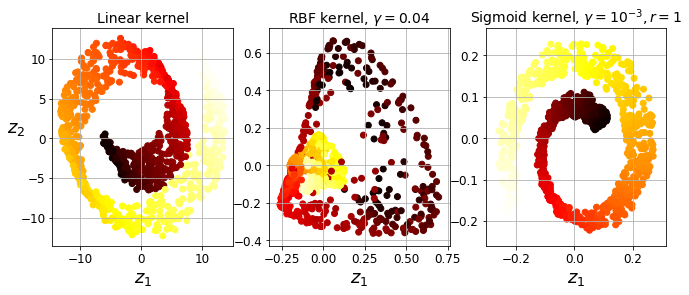

In [49]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

선형 커널, RBF 커널, 시그모이드(로지스틱) 커널을 사용하여 2차원으로 축소시킨 스위스 롤의 모습입니다.

# 8.4.1 커널 선택과 하이퍼파라미터 튜닝

kPCA는 비지도 학습이기 때문에 좋은 커널과 하이퍼파라미터를 선택하기 위한 명확한 성능 측정 기준이 없습니다.  
하지만 차원 축소는 종종 지도 학습의 전처리 단계로 활용되므로 그리드 탐색을 사용하여 주어진 문제에서 성능이 가장 좋은 커널과 하이퍼파라미터를 선택할 수 있습니다.  
예를들어 다음 코드는 두 단계의 파이프라인을 만드는데, 먼저 kPCA를 사용해 차원을 2차원으로 축소하고 분류를 위해 로지스틱 회귀를 적용합니다.  
그런 다음 파이프라인 마지막 단계에서 가장 높은 분류 정확도를 얻기 위해 GridSearchCV를 사용해 kPCA의 가장 좋은 커널과 gamma 파라미터를 찾습니다.

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="liblinear"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                 

In [51]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [52]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [53]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576611